# Multi-Agent Conversation & Debates using LangGraph and Langchain
#### Conducting debate and deciding a winner using Multi-Agent orchestration

- The user gives a debate topic
-  Two agents (for the motion & against the motion )
- They debate over the topic counterking the previous response by the opponent
- Once a certain conversation length threshold is hit the jury is called
- The jury summarize the debate and decides a winner

## Import packages and Load LLM




In [ ]:
!pip install langgraph langchain  langchain_community


In [2]:
from typing import Dict , TypedDict , Optional
from langgraph.graph import StateGraph , END
from langchain.llms import  HuggingFaceHub

from google.colab import userdata

hg_api =  userdata.get('hugginface_key')
import os
os.environ['HUGGINGFACEHUB_API_TOKEN'] = hg_api

llm  =  HuggingFaceHub(repo_id="HuggingFaceH4/zephyr-7b-beta", model_kwargs={"temperature":0.5, "max_length":512})

<ipython-input-2-2f0bfc46a15c>:11: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm  =  HuggingFaceHub(repo_id="HuggingFaceH4/zephyr-7b-beta", model_kwargs={"temperature":0.5, "max_length":512})


## Debate Topic (this can be anything)  

In [3]:
debate_topic =  "Should Data Scientists write backned and API codes as well ? "

## Deciding over the two agents

In [4]:
from langchain.output_parsers import CommaSeparatedListOutputParser
output_parser = CommaSeparatedListOutputParser()
output = llm("I wish to have a debate on {}. What would be the fighting sides called? Output just the names and nothing else as comma separated list".format(debate_topic))
classes = output_parser.parse(output)


<ipython-input-4-2910aff3c131>:3: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = llm("I wish to have a debate on {}. What would be the fighting sides called? Output just the names and nothing else as comma separated list".format(debate_topic))


In [5]:
print(classes)

['I wish to have a debate on Should Data Scientists write backned and API codes as well ? . What would be the fighting sides called? Output just the names and nothing else as comma separated list.\n\nI would say the two sides would be:\n\n1. Yes', 'Data Scientists should write back-end and API codes:\n- Data Scientists have a deep understanding of the data and the business domain', 'making them well-suited to write code that extracts insights and generates meaningful outputs.\n- Writing back-end and API codes allows Data Scientists to have greater control over the data pipeline', 'leading to faster and more efficient model development and deployment.\n-']


## For the given topic , the Two agents created are  
# ‘Data Scientists’ & ‘Full-Stack Developers’



## Defining State variables inn Graph and workflow object :
- **Classification :** To check who speak next  
- **History :** The Conversation so far
- **Current_response:** Last line spoken by any agent

- **Count:** Conversation Length

- **Results:** Verdict by Jury

- **Greeting:**  Welcome message

In [10]:
class GraphState(TypedDict):
    classification: Optional[str] = None
    history: Optional[str] = None
    current_response: Optional[str] = None
    count: Optional[int]=None
    results: Optional[str]=None
    greeting: Optional[str]=None

workflow = StateGraph(GraphState)

### Decide over nodes

In [11]:
prefix_start= "You are in support of {} . You are in a debate with {} over the topic: {}. This is the conversation so far \n{}\n.  Put forth your next argument to support {} countering {}. Dont repeat your previous arguments. Give a short, one line answer."

In [12]:
prefix_start

'You are in support of {} . You are in a debate with {} over the topic: {}. This is the conversation so far \n{}\n.  Put forth your next argument to support {} countering {}. Dont repeat your previous arguments. Give a short, one line answer.'

In [13]:
def classify(question):
    return llm("classify the sentiment of input as {} or {}. Output just the class. Input:{}".format('_'.join(classes[0].split(' ')),'_'.join(classes[1].split(' ')),question)).strip()

In [14]:
def classify_input_node(state):
    question = state.get('current_response')
    classification = classify(question)  # Assume a function that classifies the input
    return {"classification": classification}

In [15]:
def handle_greeting_node(state):
    return {"greeting": "Hello! Today we will witness the fight between {} vs {}".format(classes[0],classes[1])}

In [16]:
from ast import arguments
def handle_pro(state) :
  summary = state.get('history', '').strip()
  current_response =state.get('current_response' ,'').strip()
  if summary == "Nothing"  :
    prompt =  prefix_start.format(classes[0],classes[1],debate_topic,"Nothing",classes[0] ,"Nothing")
    arguments = classes[0] + ":" + llm(prompt)
    summary  ="START\n"
  else :
    prompt =  prefix_start.format(classes[0],classes[1],debate_topic,summary,classes[0] ,current_response)
    return {"history" :  summary + "\n" + argument  , "current_response" : argument , "count": state.get('count')+1}

In [18]:
def handle_opp(state) :
  summary = state.get('history', '').strip()
  current_response =state.get('current_response','').strip()
  prompt = prefix_start.format(classes[1],classes[0],debate_topic,summary,classes[1],current_response)
  argument = classes[1] +":"+ llm(prompt)
  return {"history":summary+'\n'+argument,"current_response":argument,"count":state.get('count')+1}


def result(state)  :
  summary = state.get('history', '').strip()
  prompt = "Summarize the conversation and judge who won the debate. No ties are allowed.Conversation : {}".format(summary)
  return {"results":llm(prompt)}

In [19]:
workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_pro", handle_pro)
workflow.add_node("handle_opp", handle_opp)
workflow.add_node("result", result)

## Classify_input_node: It classifies who spoke the last sentence/line. It internally uses classify()

## Handle_pro & Handle_opp: Using the “History” of the conversation so far & last response by rival, produces a counter reply.

## Result: Once the conversation limit is hit, summarize the conversation and judge a winner

## **Adding Conditional Edges**

In [20]:
def decide_next_node(state) :
  return "handle_opp" if state.get('classification') == '_'.join(classes[0].split(' ')) else "handle_pro"

In [21]:
def check_conv_length(state) :
  return "result" if state.get('count') ==10 else "classify_input"

In [23]:
workflow.add_conditional_edges(
    "classify_input" ,
    decide_next_node ,
    {
        "handle_pro" : "handle_pro" ,
        "handle_opp" : "handle_opp"
    }
)


workflow.add_conditional_edges(
    "handle_pro",
    check_conv_length,
    {
        "result": "result",
        "classify_input": "classify_input"
    }
)

workflow.add_conditional_edges(
    "handle_opp",
    check_conv_length,
    {
        "result": "result",
        "classify_input": "classify_input"
    }
)


##  **1st edge:** Once the speaker for last conversation is recognized using classify_input_node, choose the alternate speaker

## **2nd & 3rd edge** basically introduces a cycle where if the conversation limit is not reached, go to other speaker else to the jury

In [24]:
workflow.set_entry_point("handle_greeting")
workflow.add_edge('handle_greeting', "handle_pro")
workflow.add_edge('result', END)

In [ ]:
app = workflow.compile()
conversation = app.invoke({'count':0,'history':'Nothing','current_response':''})

In [ ]:
print(conversation["result"])

Data Scientists: Data Scientists should write backend and API codes to ensure seamless integration of models and efficient data processing. <br>

Full-Stack Developers: Full-Stack Developers possess expertise in both frontend and backend development, ensuring comprehensive understanding and efficient implementation of data models and APIs.<br>
Data Scientists: Data Scientists deep understanding of data and modeling techniques enables them to optimize backend processes and API design for efficient data handling and model integration.<br>
Full-Stack Developers: Full-Stack Developers holistic knowledge of software development ensures efficient integration of data models, APIs, and frontend components for a cohesive user experience.<br>
Data Scientists: Data Scientists specialized knowledge allows them to optimize backend processes and API design for efficient data handling and model integration, ensuring optimal performance and accuracy in data-driven applications.<br>
Full-Stack Developers: Full-Stack Developers expertise in both frontend and backend development ensures efficient integration and optimization of data models, APIs, and user interfaces for seamless user experiences.<br>
.......

In [ ]:
print(conversation["result"])

"""
The conversation is a debate between Data Scientists and Full-Stack Developers on who is better suited to write backend and API codes for data-driven applications. Both sides present valid arguments based on their respective expertise.

Data Scientists emphasize their deep understanding of data and modeling techniques, which enables them to optimize backend processes and API design for efficient data handling and model integration. They argue that their specialized knowledge allows for optimal performance and accuracy in data-driven applications.

On the other hand, Full-Stack Developers highlight their holistic knowledge of software development, encompassing both frontend and backend expertise. They contend that this comprehensive understanding ensures efficient integration of data models, APIs, and user interfaces, resulting in seamless user experiences.

While both roles have their merits, the debate can be judged in favor of Full-Stack Developers. Their broader skillset allows them to not only optimize backend processes and APIs but also integrate them effectively with frontend components. This holistic approach ensures a cohesive user experience and maximizes the overall performance of data-driven applications.

Therefore, Full-Stack Developers emerge as the winners of this debate due to their comprehensive expertise in software development and their ability to deliver seamless user experiences. """

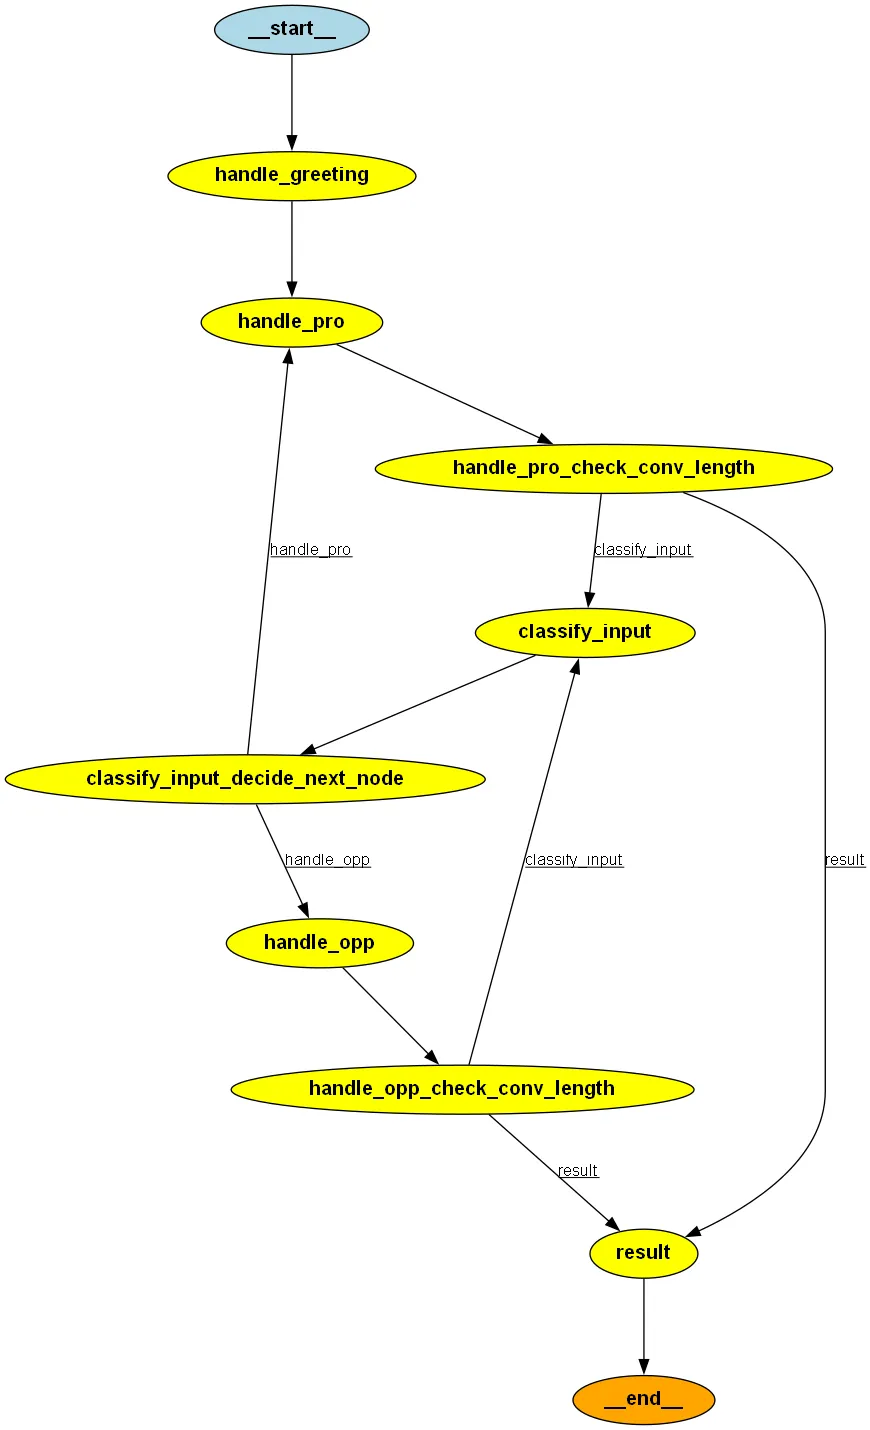

In [32]:
from IPython.display import Image

Image(filename='/content/1906_GlAFRBK3QWrRkRcghg.jpg' , width=800)